<a href="https://colab.research.google.com/github/sidhu2690/TEST-REPO/blob/main/Linear_Probe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/input/2a-data/HIGGS.csv.gz', header=None)
column_names = [
    'target', 'lepton_pt', 'lepton_eta', 'lepton_phi', 'met', 'met_phi',
    'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta',
    'jet2_phi', 'jet2_btag', 'jet3_pt', 'jet3_eta', 'jet3_pi', 'jet3_btag',
    'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag', 'm_jj', 'm_jjj', 'm_lv',
    'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'
]
df.columns = column_names

In [ ]:
import numpy as np

def transform_data(data):
    phi_indices = [2, 4, 7, 11, 15, 19]
    transformed = []
    for i in range(21):
        if i in phi_indices:
            cos_phi = np.cos(data[:, i])
            sin_phi = np.sin(data[:, i])
            transformed.append(cos_phi)
            transformed.append(sin_phi)
        else:
            transformed.append(data[:, i])
    transformed = np.stack(transformed, axis=1)
    return transformed

In [ ]:
train_features = df.iloc[:1000000, 1:22].values
probe_features = df.iloc[1000000:1100000, 1:22].values
probe_labels = df.iloc[1000000:1100000, 0].values

In [ ]:
train_features_transformed = transform_data(train_features)
probe_features_transformed = transform_data(probe_features)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_features_transformed)
probe_features_scaled = scaler.transform(probe_features_transformed)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

probe_features_tensor = torch.tensor(probe_features_scaled, dtype=torch.float32).unsqueeze(-1)
probe_labels_tensor = torch.tensor(probe_labels, dtype=torch.float32).unsqueeze(-1)

In [ ]:
probe_features_tensor.shape

torch.Size([100000, 27, 1])

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split

probe_dataset = TensorDataset(probe_features_tensor, probe_labels_tensor)
train_size = int(0.8 * len(probe_dataset))
val_size = len(probe_dataset) - train_size
train_dataset, val_dataset = random_split(probe_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [ ]:
class EnhancedTransformerEncoder(nn.Module):
    def __init__(self, input_dim=1, d_model=256, nhead=8, num_layers=4, dropout=0.3):
        super().__init__()
        self.feature_embed = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Embedding(27, d_model)
        self.dropout = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=4*d_model,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0).repeat(x.size(0), 1)
        x = self.feature_embed(x) + self.pos_encoder(positions)
        x = self.dropout(x)
        encoded = self.transformer(x)
        return encoded

class TransformerDecoder(nn.Module):
    def __init__(self, d_model=128, nhead=8, num_layers=3, dropout=0.2, seq_len=27, output_dim=1):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.tgt_emb = nn.Parameter(torch.randn(seq_len, d_model))
        self.pos_encoder = nn.Embedding(seq_len, d_model)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=4*d_model,
            dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, output_dim)

    def forward(self, memory):
        batch_size = memory.size(0)
        positions = torch.arange(0, self.seq_len, device=memory.device).unsqueeze(0).repeat(batch_size, 1)
        tgt = self.tgt_emb.unsqueeze(0).expand(batch_size, -1, -1) + self.pos_encoder(positions)
        decoder_output = self.transformer_decoder(tgt, memory)
        reconstructed = self.output_layer(decoder_output)
        return reconstructed

class EnhancedTransformerAE(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=8, num_layers=3, dropout=0.2, seq_len=27):
        super().__init__()
        self.encoder = EnhancedTransformerEncoder(input_dim, d_model, nhead, num_layers, dropout)
        self.decoder = TransformerDecoder(d_model, nhead, num_layers, dropout, seq_len, output_dim=input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded.mean(dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load("/kaggle/input/pretraining-final/best_model.pth", map_location=device, weights_only=False)

if isinstance(model, nn.DataParallel):
    encoder = model.module.encoder
else:
    encoder = model.encoder

In [ ]:
for param in encoder.parameters():
    param.requires_grad = False

In [ ]:
class Classifier(nn.Module):
    def __init__(self, encoder, d_model=128, seq_length=27):
        super().__init__()
        self.encoder = encoder
        input_dim = d_model * seq_length
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Linear(256, 1)
        )


    def forward(self, x):
        encoded = self.encoder(x)
        latent = encoded.view(encoded.size(0), -1)
        return self.classifier(latent)

In [ ]:
classifier_model = Classifier(encoder, d_model=128).to(device)

if torch.cuda.device_count() > 1:
    classifier_model = nn.DataParallel(classifier_model)

In [ ]:
optimizer = optim.Adam(classifier_model.module.classifier.parameters(), lr=1e-4, weight_decay=1e-5)

criterion = nn.BCEWithLogitsLoss()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
best_val_auc = 0.0
train_losses = []
val_losses = []
train_aucs = []
val_aucs = []

num_epochs = 20
optimizer = optim.Adam(classifier_model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, min_lr=1e-6, verbose=True)

for epoch in range(num_epochs):
    classifier_model.train()
    running_loss = 0.0
    total_samples = 0
    train_outputs_list = []
    train_targets_list = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = classifier_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier_model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
        train_outputs_list.append(outputs.detach())
        train_targets_list.append(targets.detach())

    train_loss = running_loss / total_samples
    train_losses.append(train_loss)

    train_outputs = torch.cat(train_outputs_list, dim=0)
    train_targets = torch.cat(train_targets_list, dim=0)
    train_probs = torch.sigmoid(train_outputs).cpu().numpy().flatten()
    train_targets_cpu = train_targets.cpu().numpy().flatten()
    train_auc = roc_auc_score(train_targets_cpu, train_probs)
    train_aucs.append(train_auc)

    classifier_model.eval()
    val_running_loss = 0.0
    val_samples = 0
    val_outputs_list = []
    val_targets_list = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = classifier_model(inputs)
            loss = criterion(outputs, targets)

            val_running_loss += loss.item() * inputs.size(0)
            val_samples += inputs.size(0)
            val_outputs_list.append(outputs)
            val_targets_list.append(targets)

    val_loss = val_running_loss / val_samples
    val_losses.append(val_loss)

    val_outputs = torch.cat(val_outputs_list, dim=0)
    val_targets = torch.cat(val_targets_list, dim=0)
    val_probs = torch.sigmoid(val_outputs).cpu().numpy().flatten()
    val_targets_cpu = val_targets.cpu().numpy().flatten()
    val_auc = roc_auc_score(val_targets_cpu, val_probs)
    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(classifier_model.state_dict(), "best_classifier.pth")

    scheduler.step(val_loss)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Train Loss: 0.6783 | Train AUC: 0.5870 | Val Loss: 0.6714 | Val AUC: 0.6304
Epoch 002 | Train Loss: 0.6588 | Train AUC: 0.6390 | Val Loss: 0.6481 | Val AUC: 0.6615
Epoch 003 | Train Loss: 0.6490 | Train AUC: 0.6594 | Val Loss: 0.6472 | Val AUC: 0.6673
Epoch 004 | Train Loss: 0.6416 | Train AUC: 0.6746 | Val Loss: 0.6356 | Val AUC: 0.6888
Epoch 005 | Train Loss: 0.6351 | Train AUC: 0.6857 | Val Loss: 0.6345 | Val AUC: 0.6881
Epoch 006 | Train Loss: 0.6291 | Train AUC: 0.6956 | Val Loss: 0.6554 | Val AUC: 0.6873
Epoch 007 | Train Loss: 0.6261 | Train AUC: 0.6996 | Val Loss: 0.6297 | Val AUC: 0.6984
Epoch 008 | Train Loss: 0.6215 | Train AUC: 0.7066 | Val Loss: 0.6257 | Val AUC: 0.7019
Epoch 009 | Train Loss: 0.6173 | Train AUC: 0.7126 | Val Loss: 0.6213 | Val AUC: 0.7137
Epoch 010 | Train Loss: 0.6131 | Train AUC: 0.7177 | Val Loss: 0.6161 | Val AUC: 0.7134
Epoch 011 | Train Loss: 0.6100 | Train AUC: 0.7229 | Val Loss: 0.6135 | Val AUC: 0.7203
Epoch 012 | Train Loss: 0.6065 |

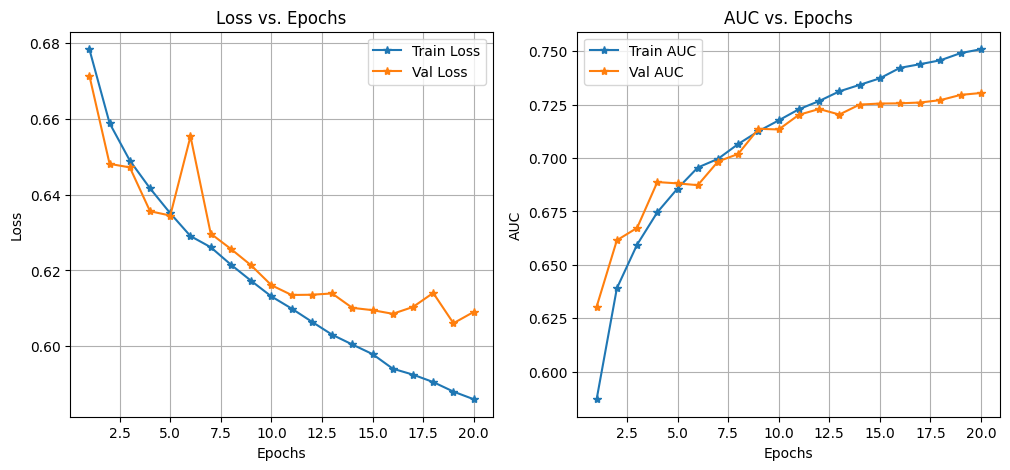

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='*')
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss", marker='*')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_aucs, label="Train AUC", marker='*')
plt.plot(range(1, num_epochs + 1), val_aucs, label="Val AUC", marker='*')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("AUC vs. Epochs")
plt.legend()
plt.grid()

plt.show()

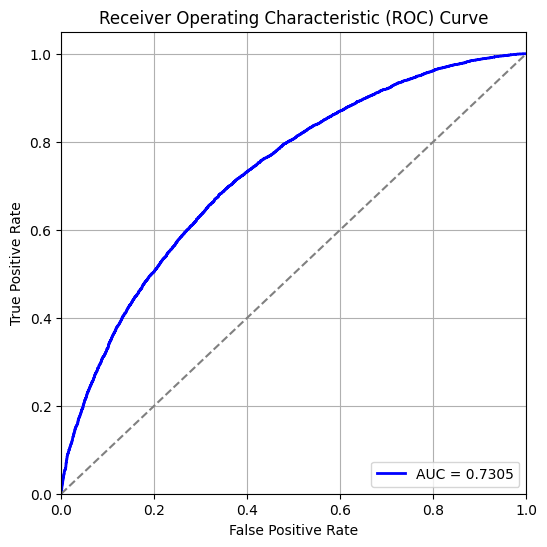

In [ ]:
fpr, tpr, _ = roc_curve(val_targets_cpu, val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()